In [33]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.profile_models as profile_models
import model.binary_models as binary_models
import extract.data_loading as data_loading
import extract.compute_predictions as compute_predictions
import extract.compute_shap as compute_shap
import plot.viz_sequence as viz_sequence
import pyBigWig
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import json
import tqdm
import h5py
tqdm.tqdm_notebook()  # It is necessary to call this before the tqdm.notebook submodule is available

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


|<bar/>| 0/? [00:00<?, ?it/s]

### Define paths for the model and data of interest

In [1]:
model_type = "binary"

In [3]:
# Shared paths/constants
reference_fasta = "/users/amtseng/genomes/mm10.fasta"
chrom_sizes = "/users/amtseng/genomes/mm10.canon.chrom.sizes"
data_base_path = "/users/amtseng/att_priors/data/processed/"
model_base_path = "/users/amtseng/att_priors/models/trained_models/%s/" % model_type
chrom_set = ["chr1"]
input_length = 1346 if model_type == "profile" else 1000
profile_length = 1000

In [4]:
# BPNet
files_spec_path = os.path.join(data_base_path, "BPNet_ChIPseq/%s/config/BPNet_training_paths.json" % model_type)
num_tasks = 1
controls = "shared"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithSharedControls
else:
    model_class = binary_models.BinaryPredictor
task_ind = 0  # Only Nanog for now
footprint_path = "/users/amtseng/att_priors/data/raw/BPNet_ChIPnexus/BPNet_NANOG_footprints.bed.gz"
pos_bigwig = "/users/amtseng/att_priors/data/raw/BPNet_ChIPnexus/BPNet_NANOG_pos.bw"
neg_bigwig = "/users/amtseng/att_priors/data/raw/BPNet_ChIPnexus/BPNet_NANOG_neg.bw"
noprior_model_path = os.path.join(model_base_path, "BPNet/17/model_ckpt_epoch_1.pt")
prior_model_path = os.path.join(model_base_path, "BPNet_prior/2/model_ckpt_epoch_10.pt")

In [5]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
def restore_model(model_path):
    model = model_util.restore_model(model_class, model_path)
    model.eval()
    model = model.to(device)
    return model

In [6]:
# Import the model without priors
noprior_model = restore_model(noprior_model_path)

In [7]:
# Import the model with priors
prior_model = restore_model(prior_model_path)

### Import footprints
For BPNet, this could just be the called IDR peaks from the ChIP-nexus assay

In [8]:
footprints = pd.read_csv(
    footprint_path, sep="\t", header=None,
    names=["chrom", "start", "end", "motifs", "orig_coord"]
)
footprints = footprints[footprints["chrom"].isin(chrom_set)]

### Create reader for BigWigs

In [26]:
def get_profiles(chrom, start, end):
    """
    Returns N x 2 array of BigWig values, negative then positive strand.
    """
    result = np.empty((end - start, 2))
    with pyBigWig.open(neg_bigwig, "r") as f:
        result[:, 0] = f.values(chrom, start, end)
    with pyBigWig.open(pos_bigwig, "r") as f:
        result[:, 1] = f.values(chrom, start, end)
    return np.nan_to_num(result)

### Compute input gradients

In [9]:
def compute_gradients(model, sample):
    """
    Given an array of N coordinates or bins, computes the input gradients
    for the model, returning an N x I x 4 array of gradient values and an
    N x I x 4 array of one-hot encoded sequence.
    """
    if model_type == "profile":
        results = compute_predictions.get_profile_model_predictions(                                              
            model, sample, num_tasks, input_func, controls=controls,                        
            return_losses=False, return_gradients=True, show_progress=True                                         
        )
    else:
        results = compute_predictions.get_binary_model_predictions(                                              
            model, sample, input_func,                      
            return_losses=False, return_gradients=True, show_progress=True                                         
        )
    return results["input_grads"], results["input_seqs"]

In [10]:
def compute_shap_scores(model, sample, batch_size=128):
    """
    Given an array of N coordinates or bins, computes the SHAP scores
    for the model, returning an N x I x 4 array of SHAP scores and an
    N x I x 4 array of one-hot encoded sequence.
    """
    num_samples = len(sample)
    num_batches = int(np.ceil(num_samples / batch_size))
    
    all_shap_scores = np.empty((num_samples, input_length, 4))
    all_one_hot_seqs = np.empty((num_samples, input_length, 4))
        
    if model_type == "profile":
        shap_explainer = compute_shap.create_profile_explainer(
            model, input_length, profile_length, num_tasks, num_strands, controls
        )
    else:
        shap_explainer = compute_shap.create_binary_explainer(
            model, input_length, num_tasks
        )

    for i in tqdm.notebook.trange(num_batches):
        batch_slice = slice(i * batch_size, (i + 1) * batch_size)
        batch = sample[batch_slice]

        if model_type == "profile":
            input_seqs, profiles = input_func(batch)
            shap_scores = shap_explainer(
                input_seqs, cont_profs=profiles[:, num_tasks:], hide_shap_output=True
            )
        else:
            input_seqs, _, _ = input_func(batch)
            shap_scores = shap_explainer(
                input_seqs, hide_shap_output=True
            )

        all_shap_scores[batch_slice] = shap_scores
        all_one_hot_seqs[batch_slice] = input_seqs
    return all_shap_scores, all_one_hot_seqs

In [11]:
if model_type == "profile":
    input_func = data_loading.get_profile_input_func(
        files_spec_path, input_length, profile_length, reference_fasta
    )
    pos_set = data_loading.get_positive_profile_coords(
        files_spec_path, task_ind=task_ind, chrom_set=chrom_set
    )
else:
    input_func = data_loading.get_binary_input_func(
        files_spec_path, input_length, reference_fasta
    )
    pos_set = data_loading.get_positive_binary_bins(
        files_spec_path, task_ind=task_ind, chrom_set=chrom_set
    )

In [12]:
sample = pos_set[np.random.choice(len(pos_set), size=1000, replace=False)]

In [16]:
# Get coordinates for the sample
if model_type == "profile":
    sample_coords = sample
else:
    sample_coords = input_func(sample)[2]

In [13]:
noprior_imp_scores, noprior_input_seqs = compute_gradients(
    noprior_model, sample
)
prior_imp_scores, prior_input_seqs = compute_gradients(
    prior_model, sample
)

100%|██████████| 8/8 [00:02<00:00,  2.81it/s]


In [14]:
assert np.all(noprior_input_seqs == prior_input_seqs)
sample_input_seqs = prior_input_seqs

In [17]:
# Pad the coordinates on both sides symmetrically to make them `input_length` 
centers = (sample_coords[:, 1] + sample_coords[:, 2]) // 2
starts = centers - (input_length // 2)
ends = starts + input_length
sample_coords[:, 1] = starts
sample_coords[:, 2] = ends

### Import the TF-MoDISco results

Metacluster: metacluster_0 (1/2)
Pattern: pattern_0 (1/7)
--------------------------------------
7408 seqlets
Sequence


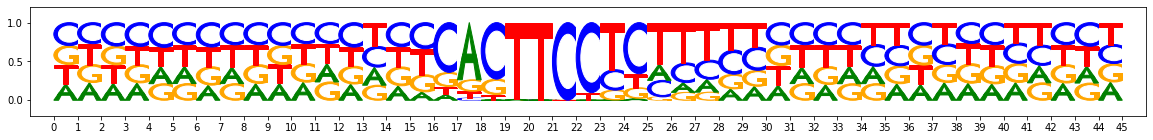

Hypothetical contributions


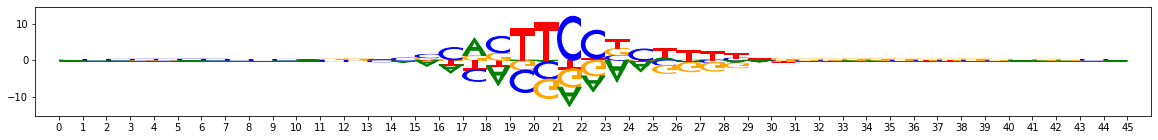

Contribution_scores


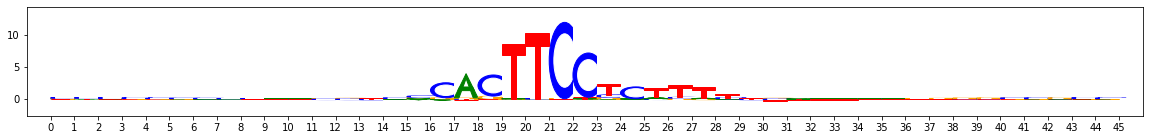

Pattern: pattern_1 (2/7)
--------------------------------------
673 seqlets
Sequence


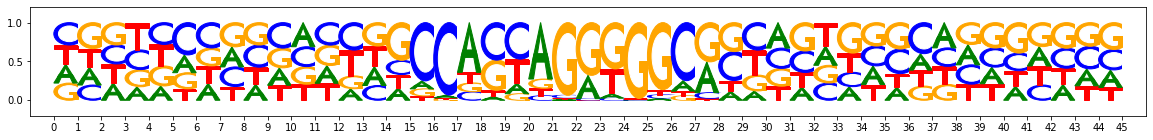

Hypothetical contributions


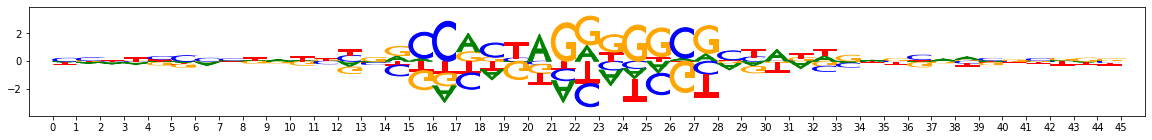

Contribution_scores


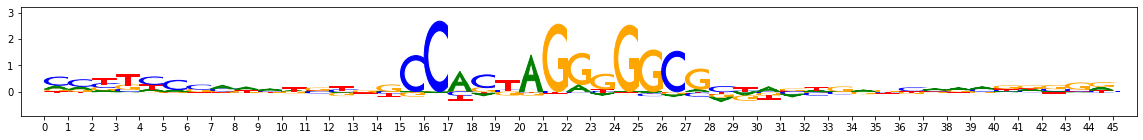

Pattern: pattern_2 (3/7)
--------------------------------------
478 seqlets
Sequence


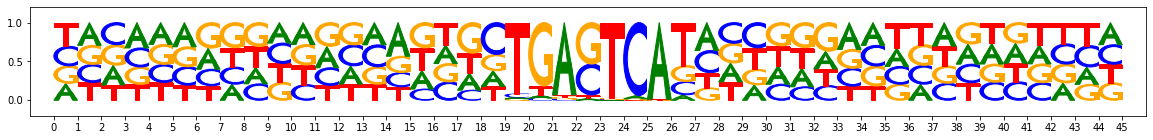

Hypothetical contributions


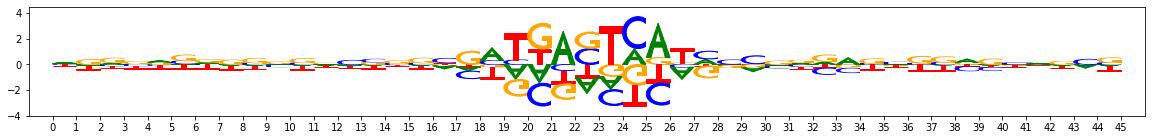

Contribution_scores


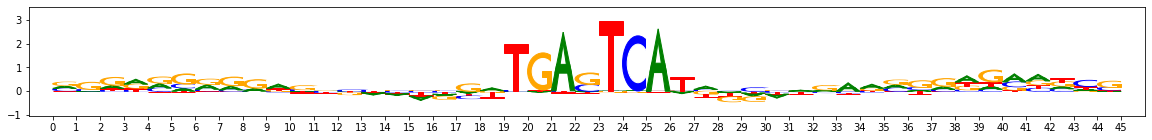

Pattern: pattern_3 (4/7)
--------------------------------------
365 seqlets
Sequence


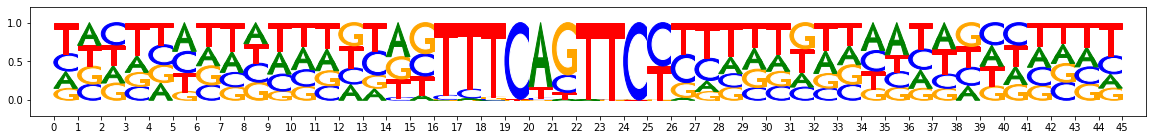

Hypothetical contributions


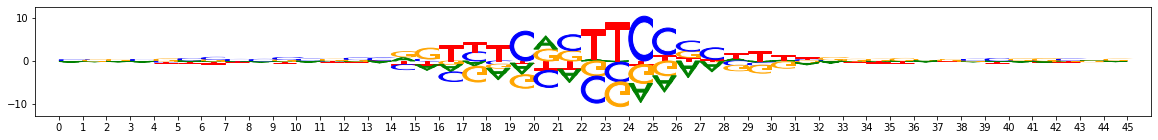

Contribution_scores


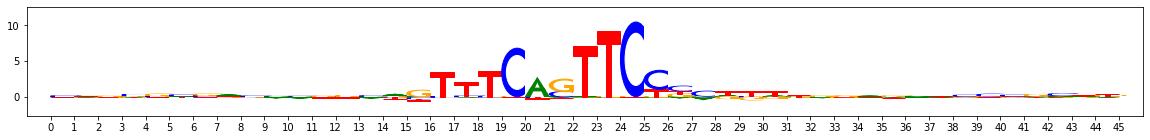

Pattern: pattern_4 (5/7)
--------------------------------------
153 seqlets
Sequence


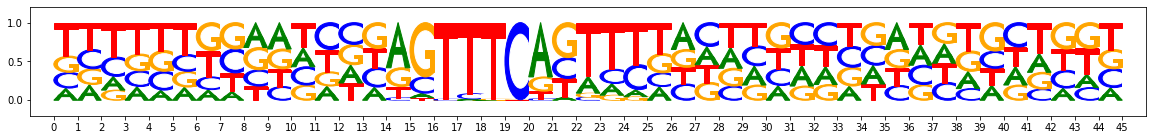

Hypothetical contributions


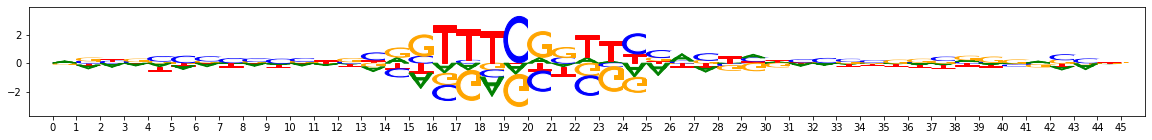

Contribution_scores


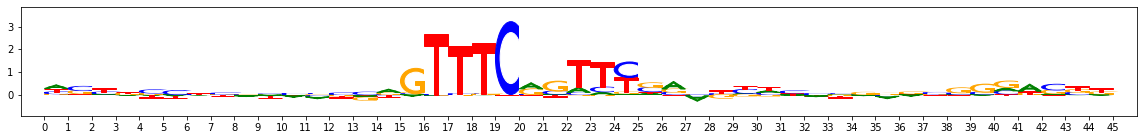

Pattern: pattern_5 (6/7)
--------------------------------------
128 seqlets
Sequence


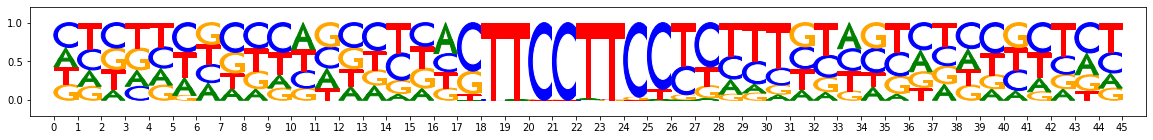

Hypothetical contributions


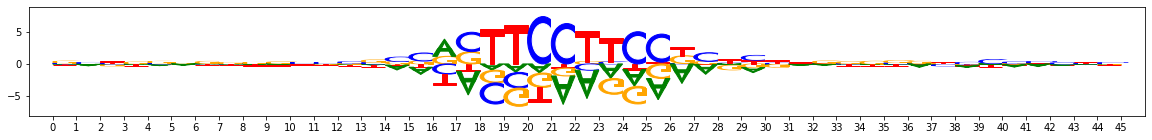

Contribution_scores


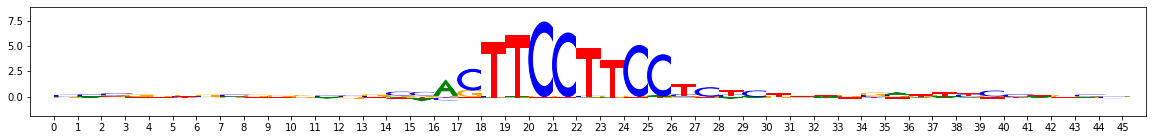

Pattern: pattern_6 (7/7)
--------------------------------------
86 seqlets
Sequence


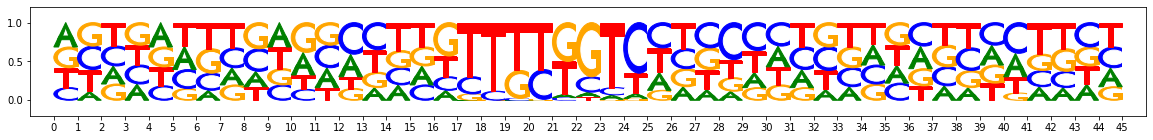

Hypothetical contributions


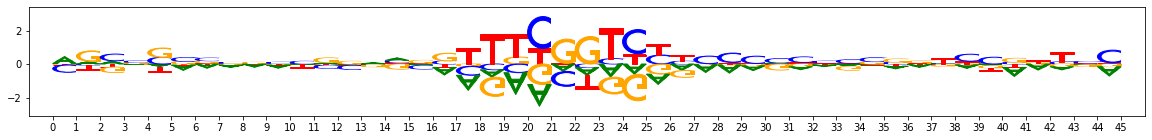

Contribution_scores


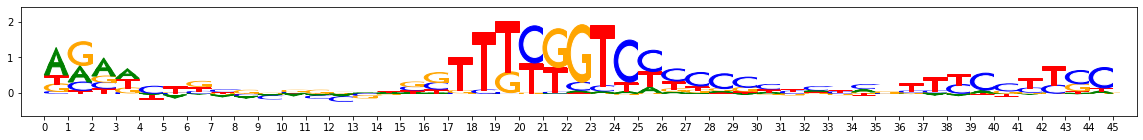

Metacluster: metacluster_1 (2/2)
Pattern: pattern_0 (1/11)
--------------------------------------
1426 seqlets
Sequence


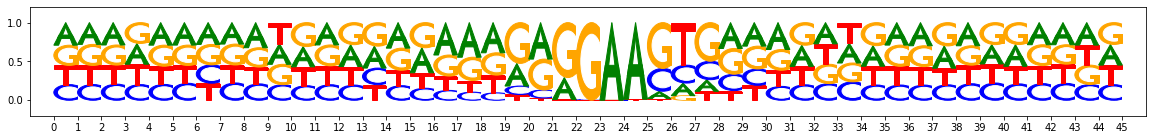

Hypothetical contributions


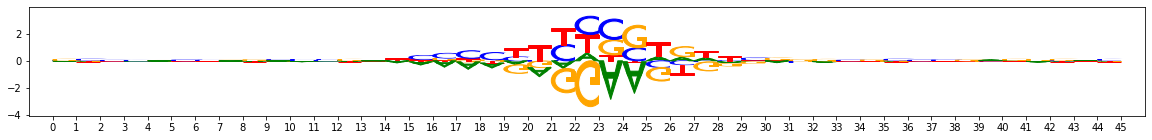

Contribution_scores


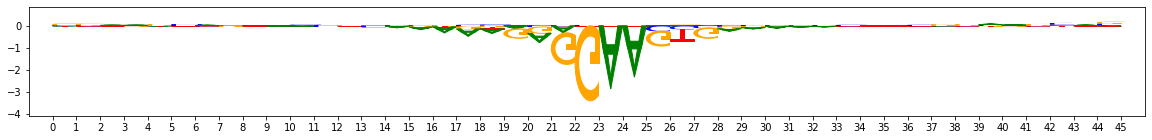

Pattern: pattern_1 (2/11)
--------------------------------------
556 seqlets
Sequence


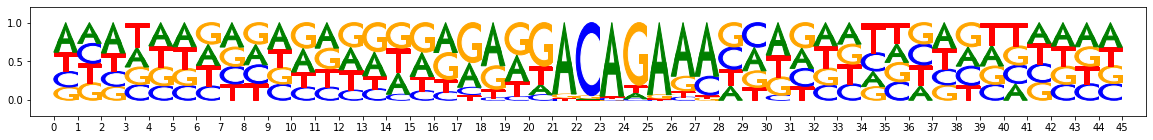

Hypothetical contributions


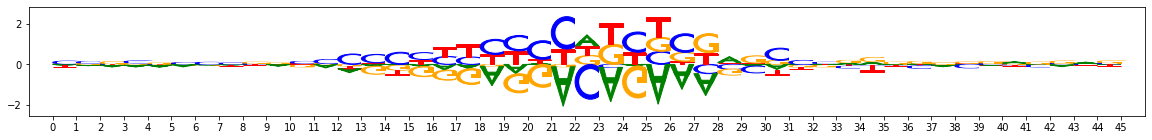

Contribution_scores


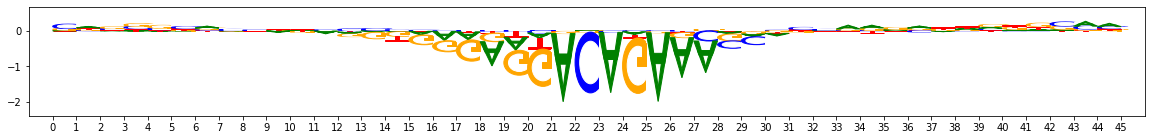

Pattern: pattern_2 (3/11)
--------------------------------------
361 seqlets
Sequence


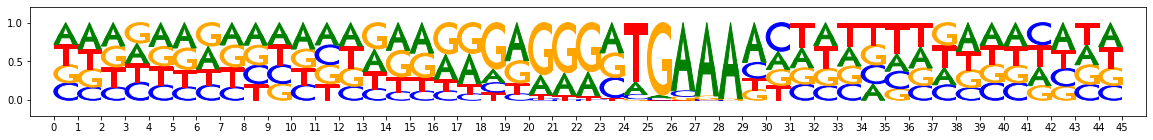

Hypothetical contributions


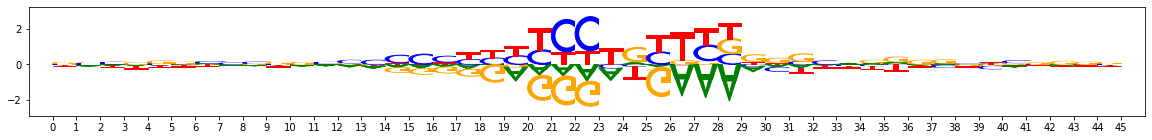

Contribution_scores


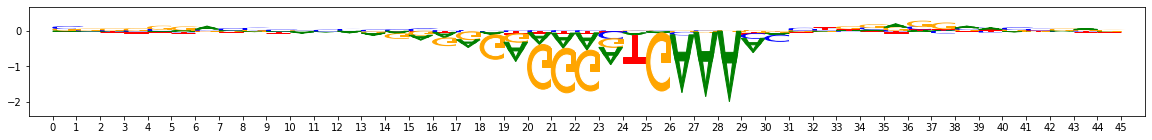

Pattern: pattern_3 (4/11)
--------------------------------------
273 seqlets
Sequence


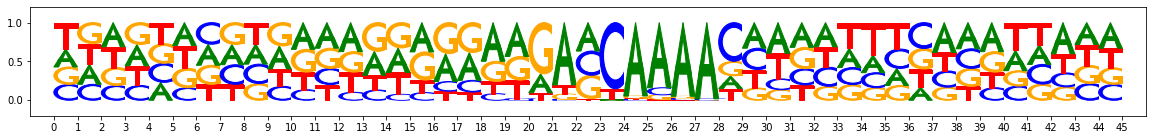

Hypothetical contributions


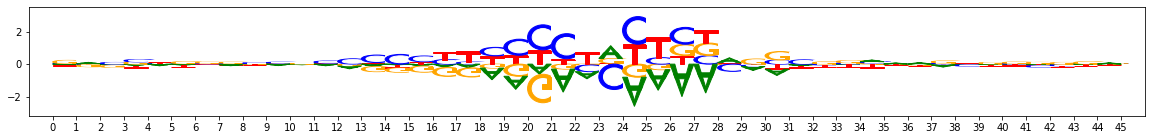

Contribution_scores


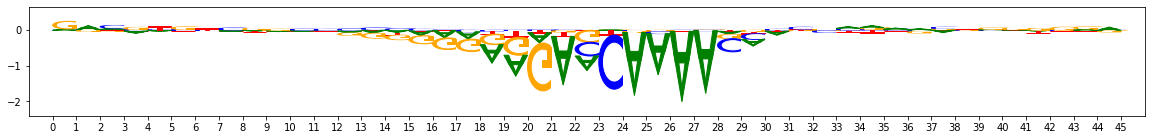

Pattern: pattern_4 (5/11)
--------------------------------------
250 seqlets
Sequence


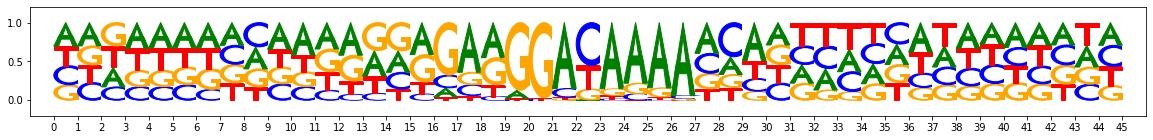

Hypothetical contributions


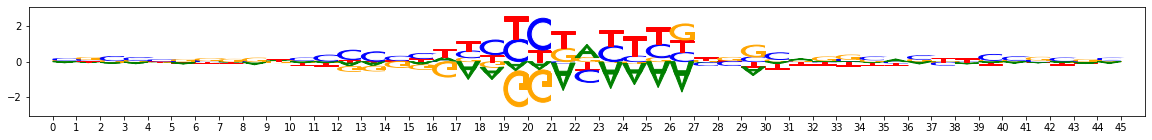

Contribution_scores


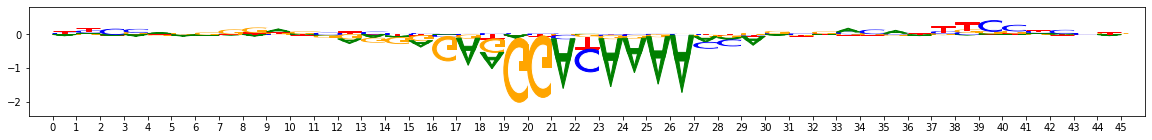

Pattern: pattern_5 (6/11)
--------------------------------------
226 seqlets
Sequence


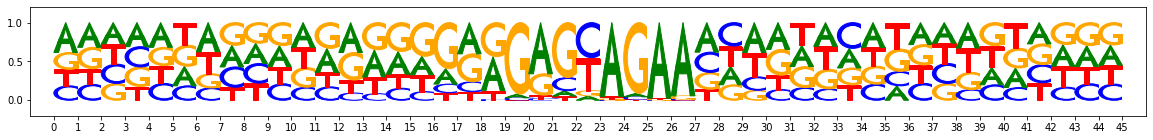

Hypothetical contributions


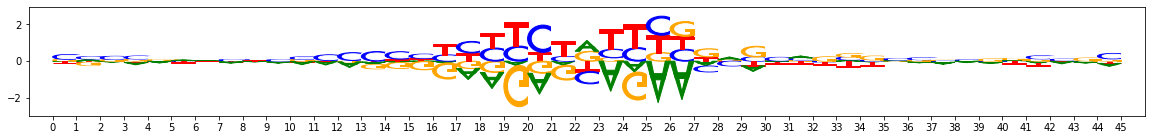

Contribution_scores


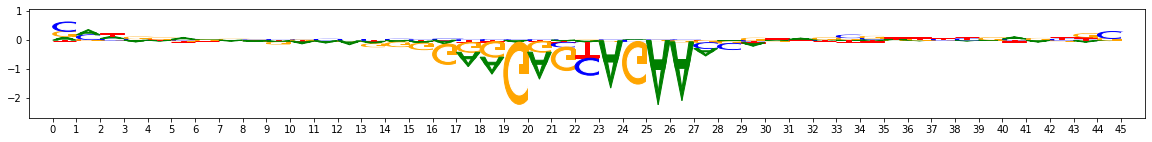

Pattern: pattern_6 (7/11)
--------------------------------------
155 seqlets
Sequence


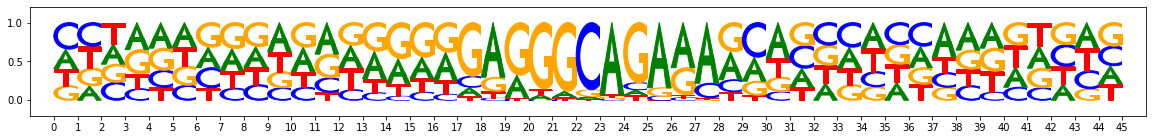

Hypothetical contributions


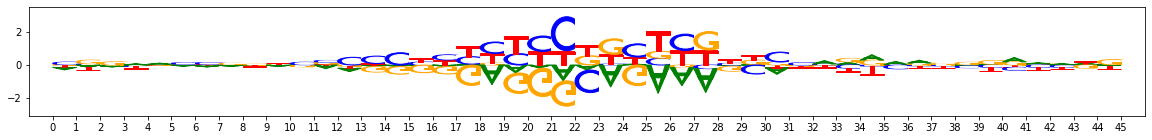

Contribution_scores


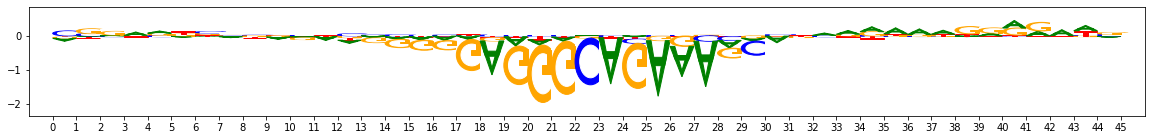

Pattern: pattern_7 (8/11)
--------------------------------------
134 seqlets
Sequence


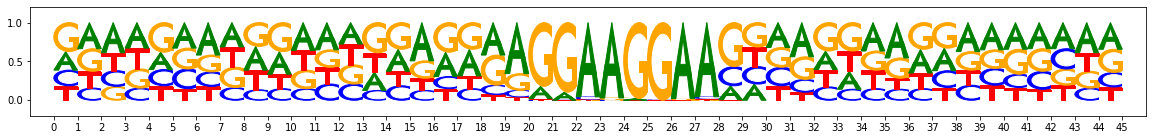

Hypothetical contributions


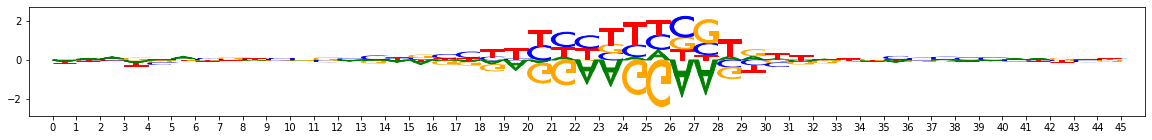

Contribution_scores


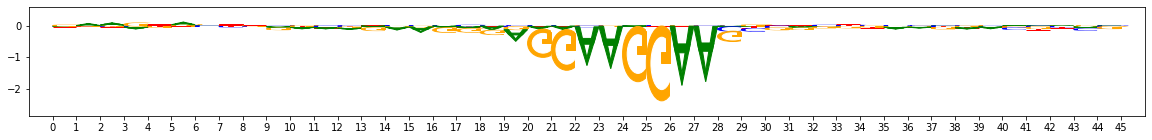

Pattern: pattern_8 (9/11)
--------------------------------------
143 seqlets
Sequence


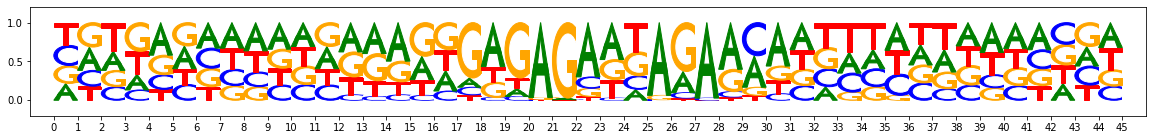

Hypothetical contributions


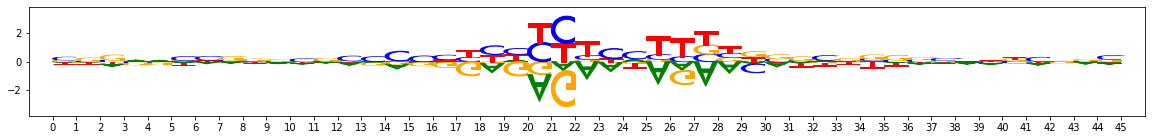

Contribution_scores


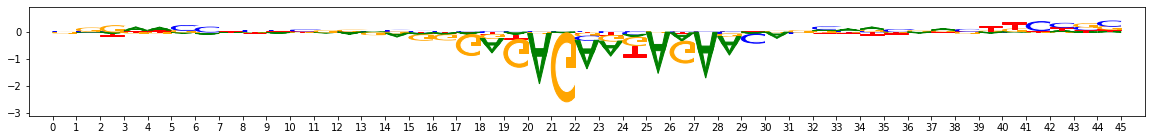

Pattern: pattern_9 (10/11)
--------------------------------------
124 seqlets
Sequence


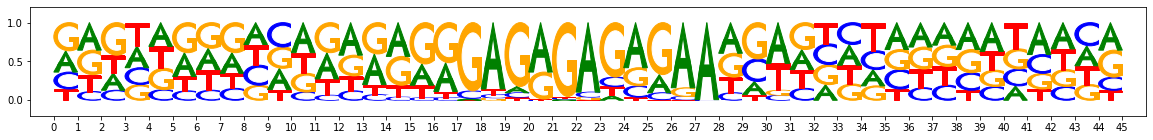

Hypothetical contributions


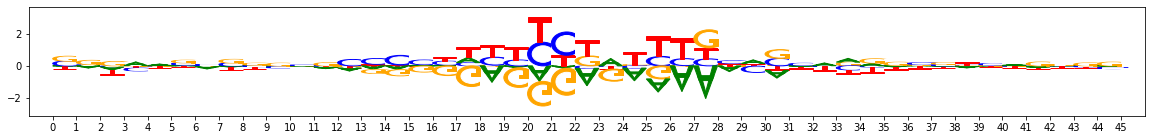

Contribution_scores


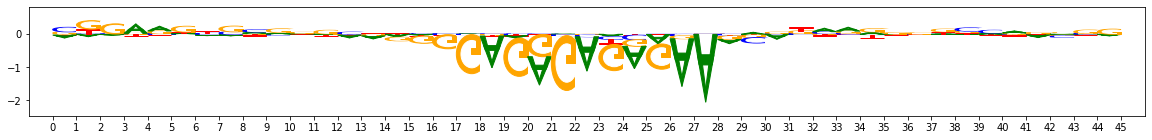

Pattern: pattern_10 (11/11)
--------------------------------------
96 seqlets
Sequence


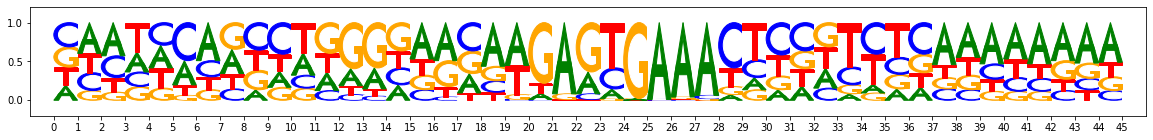

Hypothetical contributions


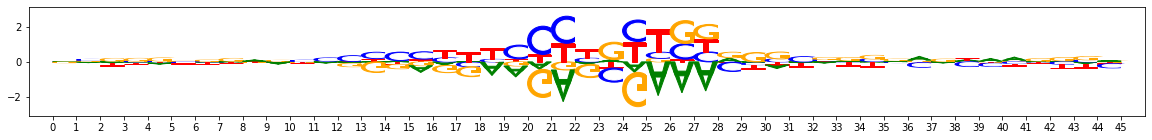

Contribution_scores


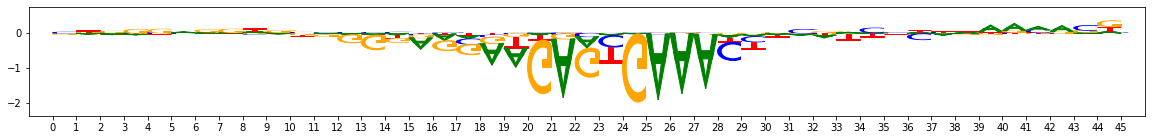

In [79]:
# Plot all motifs
with h5py.File("/users/amtseng/att_priors/results/tfmodisco/binary/SPI1_prior_tfm.h5", "r") as f:
    metaclusters = f["metacluster_idx_to_submetacluster_results"]
    num_metaclusters = len(metaclusters.keys())
    for metacluster_i, metacluster_key in enumerate(metaclusters.keys()):
        metacluster = metaclusters[metacluster_key]
        print("Metacluster: %s (%d/%d)" % (metacluster_key, metacluster_i + 1, num_metaclusters))
        print("==========================================")
        patterns = metacluster["seqlets_to_patterns_result"]["patterns"]
        num_patterns = len(patterns["all_pattern_names"][:])
        for pattern_i, pattern_name in enumerate(patterns["all_pattern_names"][:]):
            pattern_name = pattern_name.decode()
            print("Pattern: %s (%d/%d)" % (pattern_name, pattern_i + 1, num_patterns))
            print("--------------------------------------")
            pattern = patterns[pattern_name]
            seqlets = pattern["seqlets_and_alnmts"]["seqlets"]
            print("%d seqlets" % len(seqlets))
            print("Sequence")
            viz_sequence.plot_weights(pattern["sequence"]["fwd"][:])
            
            print("Hypothetical contributions")
            viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"][:])
            
            print("Contribution_scores")
            viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"][:])

### Call motif instances

### Correlate motif instances to profile heights

### Quantify agreement of motif instances with footprints using ranks